*Copyright (C) 2022 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Transforming Random Input to Given Output with a Shallow Spiking Network

_**Motivation**: In this tutorial, we will build a Lava Process representing a shallow, two layer spiking network with the Dense and LIF Processes transforming a random spiking input to an output spike pattern that resembles The Radcliffe Camera building of Oxford University, England. Starting from weights represented by floating-point numbers, we will map them Processes to the fixed-point domain with the FLoat2Fixed Converter._

#### This tutorial assumes that you:
- have the [Lava framework installed](../in_depth/tutorial01_installing_lava.ipynb "Tutorial on Installing Lava")
- are familiar with the [Process concept in Lava](../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")

#### This tutorial gives a bird's-eye view of
- how Lava Process(es) can perform the input transformation using a shallow network of
[Leaky Integrate-and-Fire (LIF)](https://github.com/lava-nc/lava/tree/main/src/lava/proc/lif "Lava's LIF neuron") neurons and [Dense
(fully connected)](https://github.com/lava-nc/lava/tree/main/src/lava/proc/dense "Lava's Dense Connectivity") connectivity
- how to create a Process 
- how to create Python ProcessModels 
- how to connect Processes
- how to execute them
- how to map a floating-point to a bit-accurate ProcessModel retaining the dynamical behavior

The input and output both consist of 200 neurons each and the spikes span approximately 1900ms. The input and output pair are converted from [SuperSpike](https://github.com/fzenke/pub2018superspike) (© GPL-3).

In [1]:
# Loading the input and target data as well as the pre-trained weights.
import numpy as np

data_dict = np.load('oxford_pretrained.npy', allow_pickle=True).item()

input_spikes = data_dict['input_spikes']
target_spikes = data_dict['target_spikes']
weights = {'weights': data_dict['weights']}

### Visualizing the data
First, we want to visualize the input and target spikes.<br>
To this end, we define an auxiliary function allowing us to display the spikes as a raster plot.

In [2]:
from matplotlib import pyplot as plt

def raster_plot(spks, stride=1, ax=None, color='b', alpha=1):
    """Generate raster plot of spiking activity.
    
    Parameters
    ----------
    
    spks : np.ndarray shape (num_neurons, timesteps)
        Spiking activity of neurons, a spike is indicated by a one    
    stride : int
        Stride for plotting neurons
    """
    num_time_steps = spks.shape[1]
    num_neurons = spks.shape[0]
    assert stride < num_time_steps, "Stride must be smaller than number of time steps"
    
    time_steps = np.arange(0, num_time_steps, 1)
    if ax is None:
        fig, ax = plt.figure(figsize=(10,5))
    timesteps = spks.shape[1]
    
    plt.xlim(-1, num_time_steps)
    plt.yticks([])
    
    plt.xlabel('Time steps')
    plt.ylabel('Neurons')
    
    for i in range(0, num_neurons, stride):
        spike_times = time_steps[spks[i] == 1]
        ax.plot(spike_times,
                 i * np.ones(spike_times.shape),
                 linestyle=' ',
                 marker='o',
                 markersize=1.5,
                 color=color,
                 alpha=alpha)
        
    return ax    

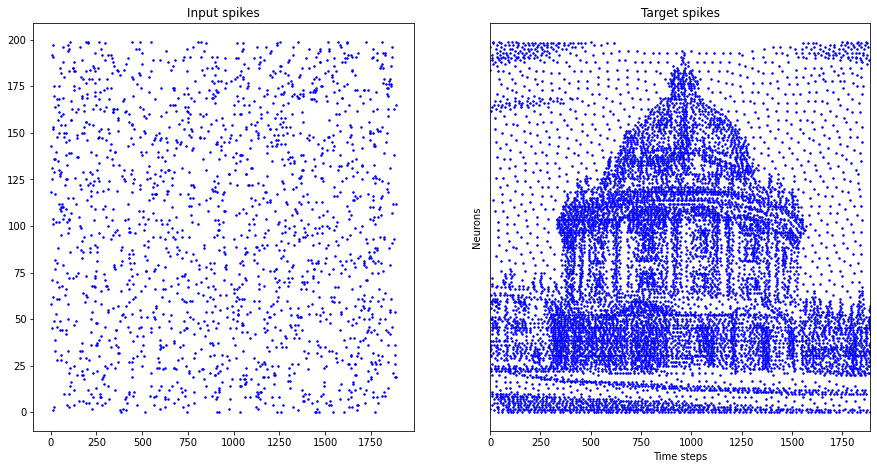

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))

ax1.set_title('Input spikes')
raster_plot(input_spikes, ax=ax1)
ax2.set_title('Target spikes')
raster_plot(target_spikes, ax=ax2)
plt.show()

### The Spiking Network
Next, we will define the network architecture.<br>
The network is a shallow, 2 layer spiking neural network, i.e. it consists of and input layer and an output layer. The input spikes are fed into the input layer according to input weights, the output layer gets activated by the input layer according to another set of weights. These weights need to be trained. Here, we fetch already pretrained weights.

In [4]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense


class ShallowSpikingNetwork:
    """Create a 2 layer spiking network with given single neuron parameters as well as input weights
       as weights between the two layers."""
    
    def __init__(self, single_neuron_params: np.ndarray,
                 weights_input: np.ndarray,
                 weights: np.ndarray):
    
        self.single_neuron_params = single_neuron_params.copy()
        self.weights_input = weights_input.copy()
        self.weights = weights.copy()
        
        self.input_layer_shape = (self.weights['weights'].shape[1],)
        self.output_layer_shape = (self.weights['weights'].shape[0],)
    
        self.input_layer = LIF(shape=self.input_layer_shape,
                               **self.single_neuron_params)
        self.output_layer = LIF(shape=self.output_layer_shape,
                                **self.single_neuron_params)
    
        self.dense_input = Dense(**self.weights_input)
        self.dense_inner = Dense(**self.weights)
    
        self.dense_input.a_out.connect(self.input_layer.s_out)
        self.input_layer.s_out.connect(self.dense_inner.s_in)
        self.dense_inner.a_out.connect(self.output_layer.a_in)

### Instantiating and running the network.
Next, we will instantiate the network to assess its performance. <br>
Before that, we need to define the missing parameters. Also, we need to set up the input and recording infrastructure.

In [5]:
# Define single neuron parameters for lIF Processes.
single_neuron_params = {'vth': 0.1,
                        'dv': 0.1,
                        'du': 1}

# Define input and inner weights.
weights_input = {'weights': 1. * np.identity(input_spikes.shape[0])}

In [6]:
# Instantiate the network.
net = ShallowSpikingNetwork(single_neuron_params, weights_input, weights)

In [7]:
# Set up io infrastructure. Moreover, we record the voltage traces from the output layer.
from lava.proc.io.source import RingBuffer as InBuffer
from lava.proc.io.sink import RingBuffer as OutBuffer
from lava.proc.monitor.process import Monitor

input_proc = InBuffer(data=input_spikes)
output_proc = OutBuffer(shape=(target_spikes.shape[0],), buffer=target_spikes.shape[1])
monitor = Monitor()

monitor.probe(target=net.output_layer.v, num_steps=target_spikes.shape[1])
input_proc.s_out.connect(net.dense_input.s_in)
net.output_layer.s_out.connect(output_proc.a_in)

In [8]:
# Defining run condition and run configuration for execution.
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

run_cond = RunSteps(num_steps=target_spikes.shape[1])
run_cfg = Loihi1SimCfg(select_tag='floating_pt')

# Executing network and fetching recorded data
net.input_layer.run(condition=run_cond, run_cfg=run_cfg)
output_spikes = output_proc.data.get()
v_output = monitor.get_data()[net.output_layer.name][net.output_layer.v.name]
net.input_layer.stop()

We finally need to compare the output generated by the network with the target spikes.

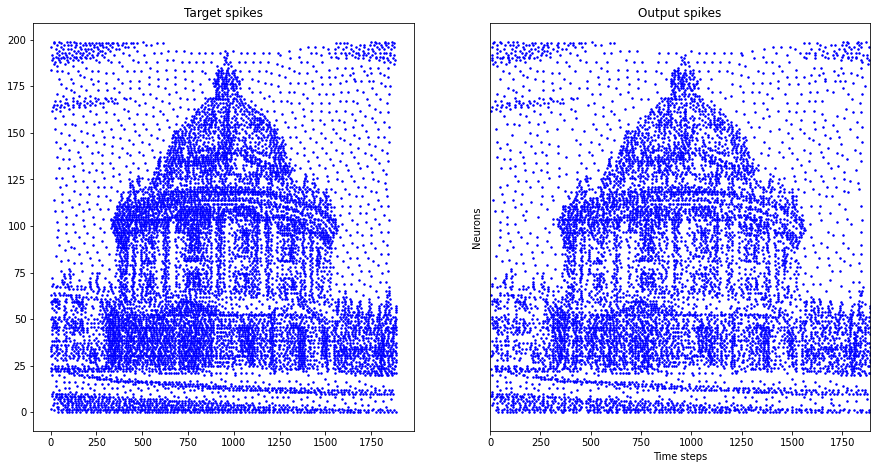

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))

ax1.set_title('Target spikes')
raster_plot(target_spikes, ax=ax1)
ax2.set_title('Output spikes')
raster_plot(output_spikes, ax=ax2)
plt.show()

We see that the trained network approximates the target output spikes well. <br>
Next, we turn to the floating- to fixed-point conversion of the model.

### Float2Fixed conversion
To run the network with bit-accurate ProcessModels of the `LIF` and `Dense` Process, we need to convert the parameters and weights from a floating- to a fixed point representation. <br>
This conversion is done with the `Float2FixedConverter`.<br>
First, we need to set up the process that we want to converter. Then we need to define run configurations for the floating- and fixed-point ProcessModels. <br>
The former are used to run the floating-point version of the network to determine the values attained by dynamical variables in the network (here `u` and `v` of the input and output `LIF` Processes), the latter is needed to obtain the information required for the conversion (precision of the representation etc.). <br> 
This allows us to optimally map the floating- to a fixed-point model. <br>
**Note**: For the sampling of the dynamical data we use a subset of the input spikes. <br>
Finally, we convert the network.

In [10]:
# Set up network.
net = ShallowSpikingNetwork(single_neuron_params, weights_input, weights)
input_proc = InBuffer(data=input_spikes[:, ::10]) # Chose every 10th input.

input_proc.s_out.connect(net.dense_input.s_in)

In [11]:
from lava.utils.float2fixed import Float2FixedConverter

converter = Float2FixedConverter()
# Set run config for floating- and fixed-point ProcessModels.
converter.set_run_cfg(fixed_pt_run_cfg=Loihi1SimCfg(select_tag='fixed_pt'),
                      floating_pt_run_cfg=Loihi1SimCfg(select_tag='floating_pt'))

converter.convert(net.dense_input, num_steps=target_spikes.shape[1])

We inspect the converted parameters. The keys of the dictionary are the Process IDs of the corresponding floating-point Process.

In [12]:
converter.scaled_params

{9: {'num_message_bits': 0,
  'a_buff': 0,
  'weights': array([[127,   0,   0, ...,   0,   0,   0],
         [  0, 127,   0, ...,   0,   0,   0],
         [  0,   0, 127, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ..., 127,   0,   0],
         [  0,   0,   0, ...,   0, 127,   0],
         [  0,   0,   0, ...,   0,   0, 127]]),
  'weight_exp': 7},
 10: {'num_message_bits': 0,
  'a_buff': 0,
  'weights': array([[ -1, -19,   0, ...,   9,   5,  11],
         [  2,   6, -13, ...,  -5,   7,  -9],
         [ 13,  11, -18, ..., -33,  25,  -9],
         ...,
         [ -1, -12,   0, ...,  -6,  -5,   6],
         [  4,  20,  -2, ...,  26,   8,  14],
         [ 10,  30, -19, ..., -11,   8,  -6]]),
  'weight_exp': 0},
 8: {'bias_exp': 0,
  'vth': 25,
  'bias_mant': 0,
  'v': 0,
  'u': 0,
  'du': 4095,
  'dv': 410}}

### Execution of bit-accurate model
Finally, we use the converterd parameters to assess the performance of the bit-accurate ProcessModels.

In [13]:
single_neuron_params_fixed = converter.scaled_params[net.output_layer.id]
weights_input_fixed = converter.scaled_params[net.dense_input.id]
weights_fixed = converter.scaled_params[net.dense_inner.id]

In [14]:
net_fixed = ShallowSpikingNetwork(single_neuron_params_fixed, weights_input_fixed, weights_fixed)
input_proc = InBuffer(data=input_spikes)
output_proc = OutBuffer(shape=(target_spikes.shape[0],), buffer=target_spikes.shape[1])
monitor = Monitor()

monitor.probe(target=net_fixed.output_layer.v, num_steps=target_spikes.shape[1])
input_proc.s_out.connect(net_fixed.dense_input.s_in)
net_fixed.output_layer.s_out.connect(output_proc.a_in)

In [15]:
net_fixed.input_layer.run(condition=run_cond, run_cfg=Loihi1SimCfg(select_tag='fixed_pt'))
output_spikes_fixed = output_proc.data.get()
v_output_fixed = monitor.get_data()[net_fixed.output_layer.name][net_fixed.output_layer.v.name]
net_fixed.input_layer.stop()

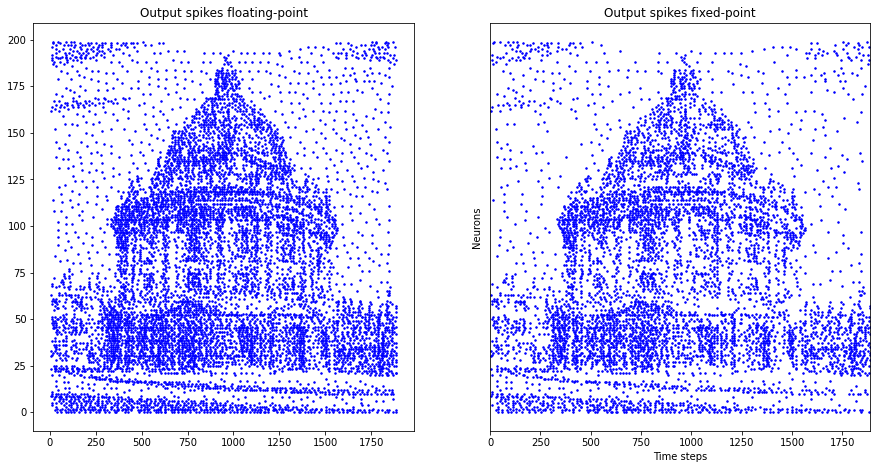

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))

ax1.set_title('Output spikes floating-point')
raster_plot(output_spikes, ax=ax1)
ax2.set_title('Output spikes fixed-point')
raster_plot(output_spikes_fixed, ax=ax2)
plt.show()

We see a degradation in performance after the floating- to fixed-point conversion. This degradation is expected due to the threshold non-linearity. <br>
Still, also the output using the bit-accurate ProcessModels approximate the target reasonably well. <br>
**Note** however, that the quality of the mapping also degrades with the number of layers to the point that the functionality is lost. Nonetheless, the procedure might be worthwhile to find a good numerical representation for the variables as well as an optimized special condition (the converted weights) with which an algorithm tailored to fixed-point numerics can start. <br> 
We finally compare the voltage traces of some neurons in the output layer. For this, we also need to define the conversion function from fixed- to floating-point.

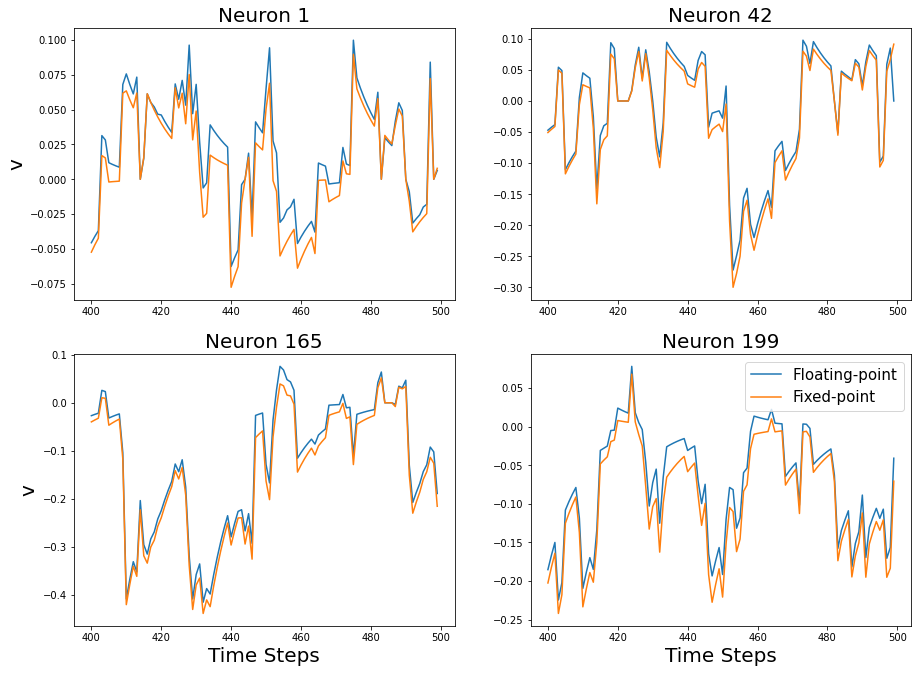

In [17]:
inv_conversion_fct = lambda x: x / converter.scaling_factors[0]
start_plot = 400
stop_plot = 500
time_steps = np.arange(start_plot, stop_plot, 1)

neuron_1 = 1
neuron_2 = 42
neuron_3 = 165
neuron_4 = 199

fig, ax = plt.subplots(2, 2, figsize=(15, 11))
ax[0, 0].set_title(f'Neuron {neuron_1}', size=20)
ax[0, 0].plot(time_steps, v_output[start_plot:stop_plot, neuron_1], label='Floating-point')
ax[0, 0].plot(time_steps, inv_conversion_fct(v_output_fixed[start_plot:stop_plot, neuron_1]), label='Fixed-point')
ax[0, 0].set_ylabel('v', size=20)
ax[0, 1].set_title(f'Neuron {neuron_2}', size=20)
ax[0, 1].plot(time_steps, v_output[start_plot:stop_plot, neuron_2], label='Floating-point')
ax[0, 1].plot(time_steps, inv_conversion_fct(v_output_fixed[start_plot:stop_plot, neuron_2]), label='Fixed-point')
ax[1, 0].set_title(f'Neuron {neuron_3}', size=20)
ax[1, 0].plot(time_steps, v_output[start_plot:stop_plot, neuron_3], label='Floating-point')
ax[1, 0].plot(time_steps, inv_conversion_fct(v_output_fixed[start_plot:stop_plot, neuron_3]), label='Fixed-point')
ax[1, 0].set_xlabel('Time Steps', size=20)
ax[1, 0].set_ylabel('v', size=20)
ax[1, 1].set_title(f'Neuron {neuron_4}', size=20)
ax[1, 1].plot(time_steps, v_output[start_plot:stop_plot, neuron_4], label='Floating-point')
ax[1, 1].plot(time_steps, inv_conversion_fct(v_output_fixed[start_plot:stop_plot, neuron_4]), label='Fixed-point')
ax[1, 1].set_xlabel('Time Steps', size=20)

plt.legend(prop={'size': 15})
plt.show()

We see a good, albeit not perfect, match between the volatge traces when using the floating- as well as fixed-point ProcessModels.

## How to learn more?

#### Follow the links below for deep-dive tutorials on the concepts in this tutorial:
- [Processes](../in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](../in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Connections](../in_depth/tutorial05_connect_processes.ipynb "Tutorial on Connecting Processe")
- [Execution](../in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Float2FixedConverter](../in_depth/tutorial10_float2fixed_conversion.ipynb)

If you want to find out more about Lava, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava/ "Lava Source Code").

To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").